## Dataset Pre-processing and statistics

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold

import torch
from torch import save, load
from torch_geometric.loader import DataLoader
from torch_geometric.utils import scatter

import utils
from utils import Dataset_from_sentences

In [4]:
df=pd.read_csv("content/Corona_NLP_train.csv", encoding='latin1')
df.head

<bound method NDFrame.head of        UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrb

In [5]:
df.shape

(41157, 6)

In [6]:
# checking for null values
overview=pd.concat([df.isnull().sum(),df.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview
# and removing them:
idx=df.loc[df.Location.isnull()].index
df_clean=df.drop(idx)
df_clean.shape

(32567, 6)

In [7]:
overview=pd.concat([df_clean.isnull().sum(),df_clean.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,32567
ScreenName,0,32567
Location,0,12220
TweetAt,0,30
OriginalTweet,0,32567
Sentiment,0,5


In [8]:
# dropping columns
df.drop(columns=['UserName','ScreenName','Location','TweetAt'], inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [9]:
sentiments=df.Sentiment.value_counts()
sentiments

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

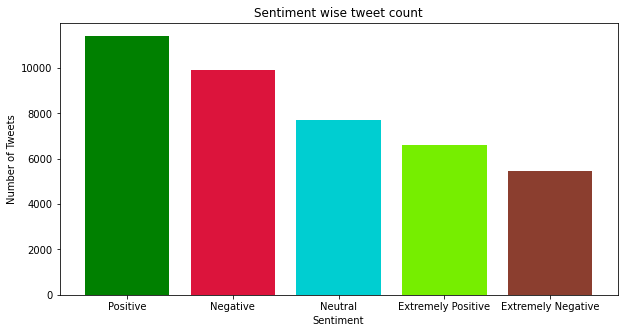

In [10]:
plt.subplots(figsize=(10,5))
plt.bar(sentiments.index,sentiments.values, color=['green','#DC143C','#00CED1','#76EE00','#8B3E2F'])
plt.title("Sentiment wise tweet count")
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

C:\Users\giova\AppData\Local\Temp\ipykernel_18340\3089917171.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_lengths)


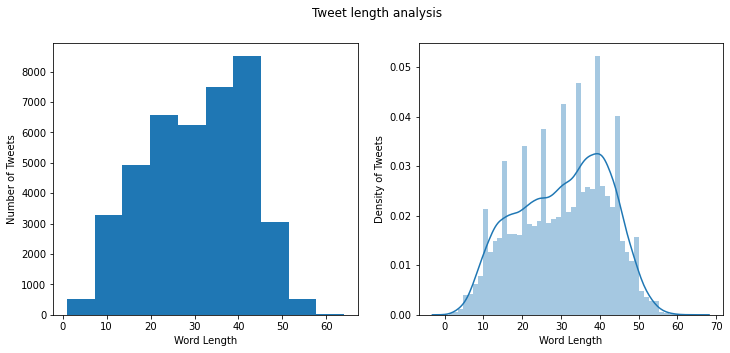

In [11]:
tweet_lengths = df['OriginalTweet'].apply(lambda x: len(x.split()))

plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(tweet_lengths)
plt.suptitle("Tweet length analysis")
plt.xlabel("Word Length")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.distplot(tweet_lengths)
plt.xlabel("Word Length")
plt.ylabel("Density of Tweets")
plt.show()

In [12]:
def get_long_tweets(df, tweet_lengths):
    to_retrun = df.loc[tweet_lengths >= 20]
    return to_retrun

df_lengthy = get_long_tweets(df, tweet_lengths)
print(df_lengthy.shape)
samples = df_lengthy["OriginalTweet"][100:110]

def print_samples(samples):
    for elem in samples:
        print("__________")
        print(elem)
        
print_samples(samples)

(32435, 2)
__________


#Covid_19 #pricegougers #Hoarders #Idiots #panicbuying #selfishpeople https://t.co/TWlpw3q0mj
__________




Â Senate fighting about other issues
__________

https://t.co/MhUu7mffPT
__________
@AirCanada very poor customer service if you let the algorithms run the prices up in states of emergency and do not refund the cost. Also very poor staffing @Airport_FRA #COVID2019
__________



#COVID?19 #coronavirus https://t.co/TMQH0CSeIN
__________
If you temporarily lost your job, check out Amazon. They are hiring to handle surge of coronavirus related buying. https://t.co/xQq7wqaGid
__________
@cgafun @DanielAndrewsMP My daughter is 16, and has stories like that from her friends with supermarket jobs. One of them said "Why do adults act like COVID-19 is my fault?". Or having to stand up to a middle-aged woman who refused to put back 5 boxes of 
__________
Currently self isolating as IÂm symptomatic. Thinking how to support elderly neighbour/ friend. IÂve done her 

In [13]:
stri = "â"
print(ord(stri))
print("".join(c if ord(c)!=226 else "a" for c in stri))

226
a


In [14]:
# tweet cleaning
# tweets with a low number of tokens should be eliminated

def preprocessing(x):
    
    def remove_hashtags(text): return re.sub(r'#', '' , text)
    def remove_mentions(text): return re.sub(r'@', '' , text)
    def remove_urls(text): return re.sub(r'https?://\S+', ' ', text)
    def change_apostrophe(text): return re.sub(r"Â", "\'", text)
    def remove_special_chars(text): return re.sub(r"[^\w. ',-]", ' ', text)
    def remove_numbers(text): return re.sub(r'[\d]', ' ', text)
    def remove_formatting_symbols(text): return re.sub(r"[\r\n]+",'',text)
    def remove_escape_characters(text): return re.sub(r"\\",'',text)
    def remove_extra_spaces(text): return re.sub(r"\s{2,}",' ',text)
    def remove_space_before_period(text): return re.sub(r"\s\.", ".", text)
    def remove_strange_a(text): return "".join(c if ord(c)!=226 else "a" for c in text )
    x=x.apply(remove_hashtags)
    x=x.apply(remove_mentions)
    x=x.apply(remove_urls)
    x=x.apply(change_apostrophe)
    x=x.apply(remove_special_chars)
    x=x.apply(remove_numbers)
    x=x.apply(remove_formatting_symbols)
    x=x.apply(remove_escape_characters)
    x=x.apply(remove_extra_spaces)
    x=x.apply(remove_space_before_period)
    x=x.str.lower()
    x=x.apply(remove_strange_a)
    return x

In [15]:
modified_sample = preprocessing(samples)

def plot_samples_graph(samples):
    for elem in samples:
        temp_glove_graph, tokens = __build_graph_Data_with_GloVe__(elem, 0, True, True)
        print(temp_glove_graph)
        print(tokens)
        visualize_graph(temp_glove_graph, tokens)
        
for elem in modified_sample:
    print("___")
    print(elem)

___
it's fringing idiots like him who have caused prices to rise amp create shortages. he's also probably wasted a lot of money as some will have expiry dates. shopkeepers must use rationing to be fair to customers. covid_ pricegougers hoarders idiots panicbuying selfishpeople 
___
congress temporarily paralyzed a house still finalizing technical corrections to coronavirus bill a replouiegohmert currently holding it up anyway, insisting bill be read on the floor, which would require house returning a senate fighting about other issues
___
the consumer financial protection bureau has reported that one employee tested positive for covid-. federal financial regulators are mandating that most employees work from home. 
___
aircanada very poor customer service if you let the algorithms run the prices up in states of emergency and do not refund the cost. also very poor staffing airport_fra covid 
___
i love this all grocery stores should have a set hour preferably in the morning for the elde

In [16]:
#%%time
df_lengthy['OriginalTweet']=preprocessing(df_lengthy['OriginalTweet'])
df_lengthy

C:\Users\giova\AppData\Local\Temp\ipykernel_18340\123162112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lengthy['OriginalTweet']=preprocessing(df_lengthy['OriginalTweet'])


,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,Positive
3,my food stock is not the only one which is emp...,Positive
4,"me, ready to go at supermarket during the covi...",Extremely Negative
5,as news of the region's first confirmed covid-...,Positive
6,cashier at grocery store was sharing his insig...,Positive
...,...,...
41149,still shocked by the number of toronto superma...,Negative
41150,i never that we'd be in a situation amp world ...,Positive
41151,mrsilverscott you are definitely my man. i fee...,Extremely Positive
41153,response to complaint not provided citing covi...,Extremely Negative


In [17]:
# checking random tweet:
df_lengthy.iloc[32432,0]

'mrsilverscott you are definitely my man. i feel like this fall when we are out and about again, we need to honor our heroes from covid-. you know who they are a our healthcare people , grocery store owners, and anyone else putting their life on the li'

In [18]:
# function to build sentiment wisewordcloud:
def show_wordcloud(df):
    sentiments=df.Sentiment.value_counts().index.to_list()
    
    stopwords = set(STOPWORDS)
    
    plt.subplots(figsize=(14,14))
    i=1
    for senti in sentiments:
        curr=df['OriginalTweet'].loc[df.Sentiment==senti]
        text=curr.values
        text=' '.join(text)
        
        wordcloud=WordCloud(max_words=100, stopwords=stopwords, background_color='white', max_font_size=50).generate(text)
        
        plt.subplot(3,2,i)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(senti,fontsize=15)
        i+=1

CPU times: total: 5.31 s
Wall time: 5.54 s


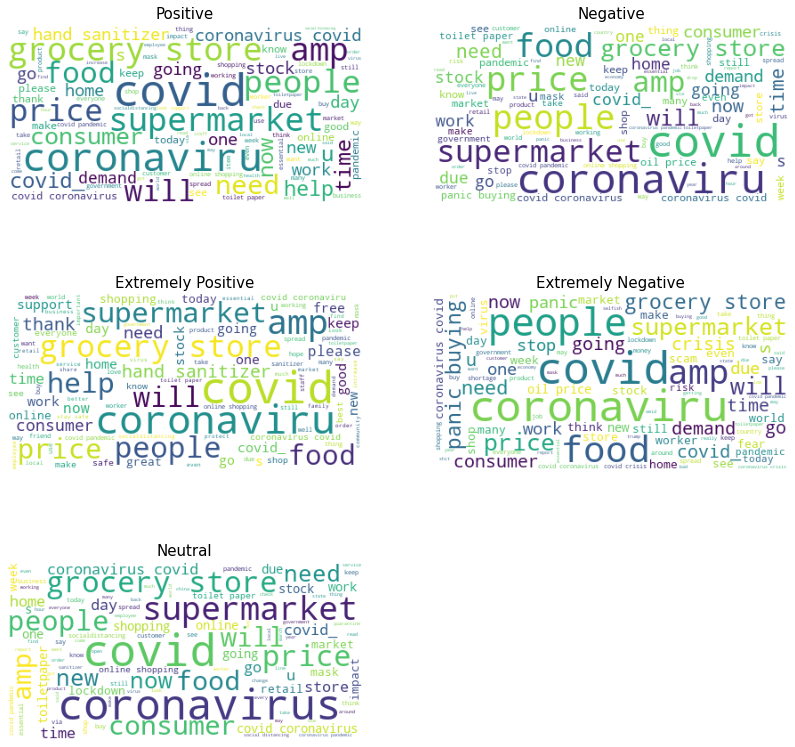

In [19]:
%%time
# generating wordclouds:
show_wordcloud(df_lengthy)

In [20]:
# function for label reduction and encoding:
def label_preprocessing(labels):
    lab_dict={
        'Extremely Negative': 0,
        'Negative': 1,
        'Neutral': 2,
        'Positive': 3,
        'Extremely Positive': 4
    }
    labels=labels.map(lab_dict)
    
    return labels

In [21]:
#%%time
# label preprocessing:
df_lengthy['Sentiment']=label_preprocessing(df_lengthy['Sentiment'])
df_lengthy

C:\Users\giova\AppData\Local\Temp\ipykernel_18340\1364274031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lengthy['Sentiment']=label_preprocessing(df_lengthy['Sentiment'])


,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,3
3,my food stock is not the only one which is emp...,3
4,"me, ready to go at supermarket during the covi...",0
5,as news of the region's first confirmed covid-...,3
6,cashier at grocery store was sharing his insig...,3
...,...,...
41149,still shocked by the number of toronto superma...,1
41150,i never that we'd be in a situation amp world ...,3
41151,mrsilverscott you are definitely my man. i fee...,4
41153,response to complaint not provided citing covi...,0


In [22]:
senti=df_lengthy['Sentiment'].value_counts()
senti

3    9263
1    7877
4    6087
0    4888
2    4320
Name: Sentiment, dtype: int64

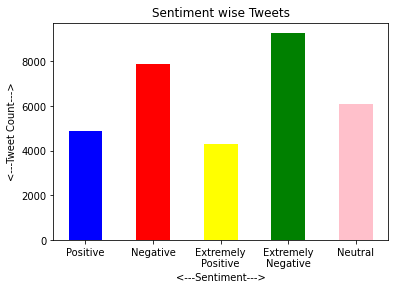

In [23]:
plt.bar(senti.index, senti.values, color=['green','red','pink', 'blue', 'yellow'], 
        align='center', width=0.5)
plt.xticks(senti.index, ['Extremely\nNegative', 'Negative', 'Neutral', 'Positive', 'Extremely\nPositive'])
plt.title('Sentiment wise Tweets')
plt.xlabel('<---Sentiment--->')
plt.ylabel('<---Tweet Count--->')
plt.show()

In [24]:
print(df_lengthy.shape)

(32435, 2)


In [25]:
df_to_use = df_lengthy
df_to_use

,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,3
3,my food stock is not the only one which is emp...,3
4,"me, ready to go at supermarket during the covi...",0
5,as news of the region's first confirmed covid-...,3
6,cashier at grocery store was sharing his insig...,3
...,...,...
41149,still shocked by the number of toronto superma...,1
41150,i never that we'd be in a situation amp world ...,3
41151,mrsilverscott you are definitely my man. i fee...,4
41153,response to complaint not provided citing covi...,0


In [26]:
df_to_use_tweet_list = df_to_use["OriginalTweet"]
tweet_list = df_to_use_tweet_list.to_list()


df_to_use_sentiments = df_to_use["Sentiment"]
sentiment_list = df_to_use_sentiments.to_list()

for index in range(0, len(tweet_list)):
  if tweet_list[index] == "":
    del tweet_list[index]
    del sentiment_list[index]

train_idx = int(len(tweet_list)*80 // 100) 

tweet_list_train = tweet_list[:train_idx]
tweet_list_test = tweet_list[train_idx:]
sentiment_list_train = sentiment_list[:train_idx]
sentiment_list_test = sentiment_list[train_idx:]

print(len(sentiment_list_train))
print(len(sentiment_list_test))

25948
6487


In [27]:
print(np.unique(sentiment_list_train, return_counts = True))
print(np.unique(sentiment_list_test, return_counts = True))

(array([0, 1, 2, 3, 4]), array([4059, 6395, 3408, 7353, 4733], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 829, 1482,  912, 1910, 1354], dtype=int64))


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# checking if the drive directory already contains the dataset
print(os.listdir("content/drive/MyDrive/GraphDataset/train/"))

In [ ]:
# run this if you wish to generate the dataset from scratch
delete_processed_files("content/processed_train/")
delete_processed_files("content/drive/MyDrive/GraphDataset/train")

delete_processed_files("content/processed_test/")
delete_processed_files("content/drive/MyDrive/GraphDataset/test")

In [29]:
# construction of the training dataset
cv19_graph_data_train = Dataset_from_sentences("train", "content/processed_train/", "content/drive/MyDrive/GraphDataset/train/", 
                                               tweet_list_train, sentiment_list_train)
cv19_graph_data_test = Dataset_from_sentences("test", "content/processed_test/", "content/drive/MyDrive/GraphDataset/test/", 
                                              tweet_list_test, sentiment_list_test)

['content/processed_train//train.pt']
['content/processed_test//test.pt']


In [ ]:
utils.g_utils.serialize_vocab("content/embed/glove_utils_object.pkl")

In [32]:
utils.g_utils.load_vocab("content/embed/glove_utils_object.pkl")

In [ ]:
# Checking if the dataset has been loaded correctly
print(cv19_graph_data_train)
print(cv19_graph_data_train.data_list)
print(len(cv19_graph_data_train))
print(cv19_graph_data_train.num_node_features)
print(cv19_graph_data_train[0]["x"].dtype)
print(len(cv19_graph_data_train.data_list.y))
print(cv19_graph_data_train.data_list[1].x)
print(cv19_graph_data_train.data_list[1].y)

In [ ]:
# Stratified K-fold Cross Validation to get stratified train-test splits

skf = StratifiedKFold(n_splits = 8)
fold_train_list = []
fold_val_list = []
print("Total number of sample in the original training set")
print(len(cv19_graph_data_train))
for i, (train_idx, val_idx) in enumerate(skf.split(cv19_graph_data_train, 
                                                   cv19_graph_data_train.data_list.y.cpu())):
    fold_train_list.append(cv19_graph_data_train[list(train_idx)])
    fold_val_list.append(cv19_graph_data_train[list(val_idx)])
    
strat_train = fold_train_list[0]
strat_val = fold_val_list[0]
print("Training and validation set obtained by means of the Stratified K-fold:")
print(strat_train, strat_val)

In [ ]:
save(strat_train, "content/processed_train/strat_train.pt")
save(strat_val, "content/processed_train/strat_val.pt")

In [34]:
strat_train = load("content/processed_train/strat_train.pt")
strat_val = load("content/processed_train/strat_val.pt")

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [36]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


print("Data built from list of sentences:\n " + str(cv19_graph_data_train))

data = cv19_graph_data_train.to(device)
print(data[0].x.get_device())
# apparently, with the "to" method we are modifying the
# elements of the inner list "data_list"; if we access the elements of 
# that list without the ".data_list" notation
# returns tensors that are on the device in the case of the features of the nodes
# while it returns tensors that are on cpu for the attribute "edge_index" and "y"
# this really makes me confused, but using the ".data_list" notation solves the problem
print(data.data_list[0].edge_index.get_device()) 
print(data.data_list[0].y.get_device())
print("________________________________")

loader =  DataLoader(cv19_graph_data_train.data_list, batch_size=10, shuffle=True)
print(f"length of the loader is {len(loader)}")

for batch in loader:
  # each minibatch is again a Data object 
  print("The current batch is the following object:\n " + str(batch))
  print("The number of graphs in the current batch is:\n " + str(batch.num_graphs))
  print("The number of nodes for this batch is: \n" + str(batch.x.shape))
  print(batch.x.device)
  print("The edge indexes for the current batch are:\n " + str(batch.edge_index.shape))
  print(batch.edge_index.device)
  print(batch.edge_index)
  print(batch.edge_index.shape[1] in batch.edge_index)
  print("The ground truth vector is:\n " + str(batch.y))
  print(batch.y.device)

  for i in range(0, batch.num_graphs):
    print("__________AAA__________")
    print(f"elem {i}:")
    print("nodes shape:\n " + str(batch[i].x.shape))
    print("edges idxs for the current sample:\n " + str(batch[i].edge_index))
    print("ground truth shape:\n " + str(batch[i].y.shape))

  # batch is a column vector that maps each node to its respective 
  # graph in the batch, it can be accessed with ".batch" and can 
  # be used to aggregate features of each nodes for each individual graph
  x = scatter(batch.x, batch.batch, dim = 0, reduce = "mean")
 
  print(batch.x.shape) 
  
  print(x.shape)
  break

<IPython.core.display.Javascript object>

Data built from list of sentences:
 Dataset_from_sentences(25948)
0
0
0
________________________________
length of the loader is 2595
The current batch is the following object:
 DataBatch(x=[411, 50], edge_index=[2, 1133], y=[10], batch=[411], ptr=[11])
The number of graphs in the current batch is:
 10
The number of nodes for this batch is: 
torch.Size([411, 50])
cuda:0
The edge indexes for the current batch are:
 torch.Size([2, 1133])
cuda:0
tensor([[  1,   2,   3,  ..., 409, 409, 410],
        [  2,   0,   2,  ..., 408, 410, 409]], device='cuda:0')
False
The ground truth vector is:
 tensor([4, 1, 3, 4, 0, 2, 0, 4, 3, 3], device='cuda:0')
cuda:0
__________AAA__________
elem 0:
nodes shape:
 torch.Size([62, 50])
edges idxs for the current sample:
 tensor([[ 1,  2,  3,  4,  1,  2,  2,  3,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13,
         14, 15, 16,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13,
         14, 14, 15, 15, 16, 18, 19, 20, 21, 22, 23, 24, 18, 19, 19, 20, 20, 21,

edges idxs for the current sample:
 tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
         17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25,
         26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34,
         35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41],
        [ 5,  5,  5,  5,  0, 14, 14, 10, 10,  7, 13, 13,  7,  5, 14, 17, 14, 17,
         17, 22, 22, 14, 26, 26, 26, 22, 28, 22, 30,  5, 32, 30, 39, 36, 36, 39,
         39, 39, 30, 41, 39,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,
          7,  9,  8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17,
         16, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26,
         25

In [37]:
# here we should plot some statistics about the graphs
# this has to be changed to something more significative

total_number_of_edges = strat_train.data_list.edge_index.shape[1]
total_number_of_nodes = strat_train.data_list.x.shape[0]
node_edges_ratio = total_number_of_edges / total_number_of_nodes

print(f'Ratio between nodes and edges: {node_edges_ratio:.2f}')

Ratio between nodes and edges: 2.75
